In [216]:
import sqlite3
import pandas as pd
import numpy as np
import pytz
from scipy import stats
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

from IPython.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

In [217]:
db_file = '/Users/brandonshimiaie/Projects/pyInvest/sqlite/db/stock.db'
conn = sqlite3.connect(db_file)

In [341]:
ticker = 'AAPL'
hist_vlm_trading_days = 22
hist_volatility_trading_days = 22
percentile_thresh = 20

backtest_start_buffer_days = 730

trade_start_hour = 14

req_volume_ratio = 1.4

In [219]:
query = f"""
SELECT * FROM BARS
WHERE TICKER = '{ticker}'
"""
df = pd.read_sql_query(query, conn)
df['DATETIME'] = pd.to_datetime(df['DATETIME'])
df['DATE'] = pd.to_datetime(df['DATE'])
df['VOLUME'] = df['VOLUME'] * df['VWAP']
df

,TICKER,DATETIME,DATE,OPEN,HIGH,LOW,CLOSE,VOLUME,TRADECOUNT,VWAP
0,AAPL,2015-12-01 09:30:00-05:00,2015-12-01,27.130,27.15,27.100,27.1100,5.401637e+07,1236,27.130000
1,AAPL,2015-12-01 09:31:00-05:00,2015-12-01,27.100,27.13,27.080,27.1200,1.897787e+07,1172,27.110000
2,AAPL,2015-12-01 09:32:00-05:00,2015-12-01,27.120,27.12,27.070,27.0900,2.020470e+07,947,27.090000
3,AAPL,2015-12-01 09:33:00-05:00,2015-12-01,27.090,27.09,27.060,27.0600,2.104127e+07,890,27.080000
4,AAPL,2015-12-01 09:34:00-05:00,2015-12-01,27.060,27.07,27.050,27.0500,1.613166e+07,846,27.060000
...,...,...,...,...,...,...,...,...,...,...
714047,AAPL,2023-03-15 15:55:00-04:00,2023-03-15,151.820,152.18,151.820,152.1400,7.863522e+07,5707,152.022325
714048,AAPL,2023-03-15 15:56:00-04:00,2023-03-15,152.160,152.36,152.115,152.3000,4.978513e+07,3521,152.228098
714049,AAPL,2023-03-15 15:57:00-04:00,2023-03-15,152.310,152.52,152.250,152.4450,5.964870e+07,4078,152.403386
714050,AAPL,2023-03-15 15:58:00-04:00,2023-03-15,152.444,152.61,152.420,152.5778,7.195375e+07,4085,152.542623


In [220]:
df['dayCumVolume'] = df.groupby('DATE')['VOLUME'].cumsum()
day_tot_volume = df.groupby('DATE')['VOLUME'].sum().reset_index()
day_tot_volume = day_tot_volume.rename(columns={
    'VOLUME': 'dayTotVolume'
})
df = df.merge(day_tot_volume, on=['DATE'], how='left')
df['pctDayVolume'] = df['dayCumVolume']/df['dayTotVolume']
df

,TICKER,DATETIME,DATE,OPEN,HIGH,LOW,CLOSE,VOLUME,TRADECOUNT,VWAP,dayCumVolume,dayTotVolume,pctDayVolume
0,AAPL,2015-12-01 09:30:00-05:00,2015-12-01,27.130,27.15,27.100,27.1100,5.401637e+07,1236,27.130000,5.401637e+07,3.415319e+09,0.015816
1,AAPL,2015-12-01 09:31:00-05:00,2015-12-01,27.100,27.13,27.080,27.1200,1.897787e+07,1172,27.110000,7.299424e+07,3.415319e+09,0.021373
2,AAPL,2015-12-01 09:32:00-05:00,2015-12-01,27.120,27.12,27.070,27.0900,2.020470e+07,947,27.090000,9.319894e+07,3.415319e+09,0.027289
3,AAPL,2015-12-01 09:33:00-05:00,2015-12-01,27.090,27.09,27.060,27.0600,2.104127e+07,890,27.080000,1.142402e+08,3.415319e+09,0.033449
4,AAPL,2015-12-01 09:34:00-05:00,2015-12-01,27.060,27.07,27.050,27.0500,1.613166e+07,846,27.060000,1.303719e+08,3.415319e+09,0.038173
...,...,...,...,...,...,...,...,...,...,...,...,...,...
714047,AAPL,2023-03-15 15:55:00-04:00,2023-03-15,151.820,152.18,151.820,152.1400,7.863522e+07,5707,152.022325,9.166291e+09,9.602318e+09,0.954591
714048,AAPL,2023-03-15 15:56:00-04:00,2023-03-15,152.160,152.36,152.115,152.3000,4.978513e+07,3521,152.228098,9.216076e+09,9.602318e+09,0.959776
714049,AAPL,2023-03-15 15:57:00-04:00,2023-03-15,152.310,152.52,152.250,152.4450,5.964870e+07,4078,152.403386,9.275725e+09,9.602318e+09,0.965988
714050,AAPL,2023-03-15 15:58:00-04:00,2023-03-15,152.444,152.61,152.420,152.5778,7.195375e+07,4085,152.542623,9.347678e+09,9.602318e+09,0.973481


In [221]:
df['time'] = df['DATETIME'].apply(lambda x: x.strftime('%H:%M:%S'))
hist_pct_volume = df.groupby('time')['pctDayVolume'].expanding().mean().reset_index().set_index('level_1').sort_index().groupby('time').shift()
hist_pct_volume = hist_pct_volume.rename(columns={
    'pctDayVolume': 'histPctDayVolume'
})
df = df.merge(hist_pct_volume, left_index=True, right_index=True, how='left')
df['estDayVolume'] = df['dayCumVolume']/df['histPctDayVolume']
df

,TICKER,DATETIME,DATE,OPEN,HIGH,LOW,CLOSE,VOLUME,TRADECOUNT,VWAP,dayCumVolume,dayTotVolume,pctDayVolume,time,histPctDayVolume,estDayVolume
0,AAPL,2015-12-01 09:30:00-05:00,2015-12-01,27.130,27.15,27.100,27.1100,5.401637e+07,1236,27.130000,5.401637e+07,3.415319e+09,0.015816,09:30:00,NaN,NaN
1,AAPL,2015-12-01 09:31:00-05:00,2015-12-01,27.100,27.13,27.080,27.1200,1.897787e+07,1172,27.110000,7.299424e+07,3.415319e+09,0.021373,09:31:00,NaN,NaN
2,AAPL,2015-12-01 09:32:00-05:00,2015-12-01,27.120,27.12,27.070,27.0900,2.020470e+07,947,27.090000,9.319894e+07,3.415319e+09,0.027289,09:32:00,NaN,NaN
3,AAPL,2015-12-01 09:33:00-05:00,2015-12-01,27.090,27.09,27.060,27.0600,2.104127e+07,890,27.080000,1.142402e+08,3.415319e+09,0.033449,09:33:00,NaN,NaN
4,AAPL,2015-12-01 09:34:00-05:00,2015-12-01,27.060,27.07,27.050,27.0500,1.613166e+07,846,27.060000,1.303719e+08,3.415319e+09,0.038173,09:34:00,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
714047,AAPL,2023-03-15 15:55:00-04:00,2023-03-15,151.820,152.18,151.820,152.1400,7.863522e+07,5707,152.022325,9.166291e+09,9.602318e+09,0.954591,15:55:00,0.962878,9.519678e+09
714048,AAPL,2023-03-15 15:56:00-04:00,2023-03-15,152.160,152.36,152.115,152.3000,4.978513e+07,3521,152.228098,9.216076e+09,9.602318e+09,0.959776,15:56:00,0.968443,9.516387e+09
714049,AAPL,2023-03-15 15:57:00-04:00,2023-03-15,152.310,152.52,152.250,152.4450,5.964870e+07,4078,152.403386,9.275725e+09,9.602318e+09,0.965988,15:57:00,0.974561,9.517854e+09
714050,AAPL,2023-03-15 15:58:00-04:00,2023-03-15,152.444,152.61,152.420,152.5778,7.195375e+07,4085,152.542623,9.347678e+09,9.602318e+09,0.973481,15:58:00,0.982053,9.518505e+09


In [222]:
hist_day_volume = day_tot_volume.set_index('DATE')['dayTotVolume'].rolling(hist_vlm_trading_days).mean().shift().reset_index().dropna()
hist_day_volume = hist_day_volume.rename(columns={
    'dayTotVolume': 'histDayVolume'
})
df = df.merge(hist_day_volume, on=['DATE'], how='left')
df['todayVsHistVolume'] = df['estDayVolume']/df['histDayVolume']
df

,TICKER,DATETIME,DATE,OPEN,HIGH,LOW,CLOSE,VOLUME,TRADECOUNT,VWAP,dayCumVolume,dayTotVolume,pctDayVolume,time,histPctDayVolume,estDayVolume,histDayVolume,todayVsHistVolume
0,AAPL,2015-12-01 09:30:00-05:00,2015-12-01,27.130,27.15,27.100,27.1100,5.401637e+07,1236,27.130000,5.401637e+07,3.415319e+09,0.015816,09:30:00,NaN,NaN,NaN,NaN
1,AAPL,2015-12-01 09:31:00-05:00,2015-12-01,27.100,27.13,27.080,27.1200,1.897787e+07,1172,27.110000,7.299424e+07,3.415319e+09,0.021373,09:31:00,NaN,NaN,NaN,NaN
2,AAPL,2015-12-01 09:32:00-05:00,2015-12-01,27.120,27.12,27.070,27.0900,2.020470e+07,947,27.090000,9.319894e+07,3.415319e+09,0.027289,09:32:00,NaN,NaN,NaN,NaN
3,AAPL,2015-12-01 09:33:00-05:00,2015-12-01,27.090,27.09,27.060,27.0600,2.104127e+07,890,27.080000,1.142402e+08,3.415319e+09,0.033449,09:33:00,NaN,NaN,NaN,NaN
4,AAPL,2015-12-01 09:34:00-05:00,2015-12-01,27.060,27.07,27.050,27.0500,1.613166e+07,846,27.060000,1.303719e+08,3.415319e+09,0.038173,09:34:00,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
714047,AAPL,2023-03-15 15:55:00-04:00,2023-03-15,151.820,152.18,151.820,152.1400,7.863522e+07,5707,152.022325,9.166291e+09,9.602318e+09,0.954591,15:55:00,0.962878,9.519678e+09,7.600539e+09,1.252500
714048,AAPL,2023-03-15 15:56:00-04:00,2023-03-15,152.160,152.36,152.115,152.3000,4.978513e+07,3521,152.228098,9.216076e+09,9.602318e+09,0.959776,15:56:00,0.968443,9.516387e+09,7.600539e+09,1.252067
714049,AAPL,2023-03-15 15:57:00-04:00,2023-03-15,152.310,152.52,152.250,152.4450,5.964870e+07,4078,152.403386,9.275725e+09,9.602318e+09,0.965988,15:57:00,0.974561,9.517854e+09,7.600539e+09,1.252260
714050,AAPL,2023-03-15 15:58:00-04:00,2023-03-15,152.444,152.61,152.420,152.5778,7.195375e+07,4085,152.542623,9.347678e+09,9.602318e+09,0.973481,15:58:00,0.982053,9.518505e+09,7.600539e+09,1.252346


In [223]:
price_df = df[['TICKER', 'DATETIME', 'DATE', 'OPEN', 'CLOSE', 'HIGH', 'LOW']]
price_df

,TICKER,DATETIME,DATE,OPEN,CLOSE,HIGH,LOW
0,AAPL,2015-12-01 09:30:00-05:00,2015-12-01,27.130,27.1100,27.15,27.100
1,AAPL,2015-12-01 09:31:00-05:00,2015-12-01,27.100,27.1200,27.13,27.080
2,AAPL,2015-12-01 09:32:00-05:00,2015-12-01,27.120,27.0900,27.12,27.070
3,AAPL,2015-12-01 09:33:00-05:00,2015-12-01,27.090,27.0600,27.09,27.060
4,AAPL,2015-12-01 09:34:00-05:00,2015-12-01,27.060,27.0500,27.07,27.050
...,...,...,...,...,...,...,...
714047,AAPL,2023-03-15 15:55:00-04:00,2023-03-15,151.820,152.1400,152.18,151.820
714048,AAPL,2023-03-15 15:56:00-04:00,2023-03-15,152.160,152.3000,152.36,152.115
714049,AAPL,2023-03-15 15:57:00-04:00,2023-03-15,152.310,152.4450,152.52,152.250
714050,AAPL,2023-03-15 15:58:00-04:00,2023-03-15,152.444,152.5778,152.61,152.420


In [226]:
def _percentile(n):
    def _percentile_h(x):
        return np.percentile(x, n)
    _percentile_h.__name__ = 'percentile_%s' % n
    return _percentile_h

def _last(x):
    return x.iloc[-1]

percentiles = price_df.groupby('DATE').agg(
    day_upper_20=('CLOSE', _percentile(100-percentile_thresh)),
    day_lower_20=('CLOSE', _percentile(percentile_thresh)),
    day_close=('CLOSE', _last),
).reset_index()

percentiles['finish_above_20'] = percentiles['day_close'] > percentiles['day_upper_20']
percentiles['finish_below_20'] = percentiles['day_close'] < percentiles['day_lower_20']

price_df = price_df.merge(percentiles, on=['DATE'], how='left')
price_df

,TICKER,DATETIME,DATE,OPEN,CLOSE,HIGH,LOW,day_upper_20,day_lower_20,day_close,finish_above_20,finish_below_20
0,AAPL,2015-12-01 09:30:00-05:00,2015-12-01,27.130,27.1100,27.15,27.100,27.030,26.79,26.81,False,False
1,AAPL,2015-12-01 09:31:00-05:00,2015-12-01,27.100,27.1200,27.13,27.080,27.030,26.79,26.81,False,False
2,AAPL,2015-12-01 09:32:00-05:00,2015-12-01,27.120,27.0900,27.12,27.070,27.030,26.79,26.81,False,False
3,AAPL,2015-12-01 09:33:00-05:00,2015-12-01,27.090,27.0600,27.09,27.060,27.030,26.79,26.81,False,False
4,AAPL,2015-12-01 09:34:00-05:00,2015-12-01,27.060,27.0500,27.07,27.050,27.030,26.79,26.81,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
714047,AAPL,2023-03-15 15:55:00-04:00,2023-03-15,151.820,152.1400,152.18,151.820,152.304,150.81,152.99,True,False
714048,AAPL,2023-03-15 15:56:00-04:00,2023-03-15,152.160,152.3000,152.36,152.115,152.304,150.81,152.99,True,False
714049,AAPL,2023-03-15 15:57:00-04:00,2023-03-15,152.310,152.4450,152.52,152.250,152.304,150.81,152.99,True,False
714050,AAPL,2023-03-15 15:58:00-04:00,2023-03-15,152.444,152.5778,152.61,152.420,152.304,150.81,152.99,True,False


In [227]:
tz = pytz.timezone('US/Eastern')
price_df['close_time'] = price_df['DATE'].apply(lambda x: pd.Timestamp(f"{x} 16:00:00", tz=tz))
price_df['minutes_to_close'] = (price_df['close_time']-price_df['DATETIME']).astype('timedelta64[m]')
price_df

,TICKER,DATETIME,DATE,OPEN,CLOSE,HIGH,LOW,day_upper_20,day_lower_20,day_close,finish_above_20,finish_below_20,close_time,minutes_to_close
0,AAPL,2015-12-01 09:30:00-05:00,2015-12-01,27.130,27.1100,27.15,27.100,27.030,26.79,26.81,False,False,2015-12-01 16:00:00-05:00,390.0
1,AAPL,2015-12-01 09:31:00-05:00,2015-12-01,27.100,27.1200,27.13,27.080,27.030,26.79,26.81,False,False,2015-12-01 16:00:00-05:00,389.0
2,AAPL,2015-12-01 09:32:00-05:00,2015-12-01,27.120,27.0900,27.12,27.070,27.030,26.79,26.81,False,False,2015-12-01 16:00:00-05:00,388.0
3,AAPL,2015-12-01 09:33:00-05:00,2015-12-01,27.090,27.0600,27.09,27.060,27.030,26.79,26.81,False,False,2015-12-01 16:00:00-05:00,387.0
4,AAPL,2015-12-01 09:34:00-05:00,2015-12-01,27.060,27.0500,27.07,27.050,27.030,26.79,26.81,False,False,2015-12-01 16:00:00-05:00,386.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
714047,AAPL,2023-03-15 15:55:00-04:00,2023-03-15,151.820,152.1400,152.18,151.820,152.304,150.81,152.99,True,False,2023-03-15 16:00:00-04:00,5.0
714048,AAPL,2023-03-15 15:56:00-04:00,2023-03-15,152.160,152.3000,152.36,152.115,152.304,150.81,152.99,True,False,2023-03-15 16:00:00-04:00,4.0
714049,AAPL,2023-03-15 15:57:00-04:00,2023-03-15,152.310,152.4450,152.52,152.250,152.304,150.81,152.99,True,False,2023-03-15 16:00:00-04:00,3.0
714050,AAPL,2023-03-15 15:58:00-04:00,2023-03-15,152.444,152.5778,152.61,152.420,152.304,150.81,152.99,True,False,2023-03-15 16:00:00-04:00,2.0


In [228]:
def get_percentile_of_score(x):
    if len(x) == 0:
        return np.nan
    return stats.percentileofscore(x, x.iloc[-1])

price_percentile = price_df.groupby('DATE')['CLOSE'].expanding().apply(lambda x: get_percentile_of_score(x)).reset_index()
price_percentile = price_percentile.set_index('level_1')
price_percentile = price_percentile.rename(columns={
    'CLOSE': 'current_price_percentile'
})
price_percentile = price_percentile.drop(columns=['DATE'])

price_df = price_df.merge(price_percentile, left_index=True, right_index=True, how='left')
price_df

,TICKER,DATETIME,DATE,OPEN,CLOSE,HIGH,LOW,day_upper_20,day_lower_20,day_close,finish_above_20,finish_below_20,close_time,minutes_to_close,current_price_percentile
0,AAPL,2015-12-01 09:30:00-05:00,2015-12-01,27.130,27.1100,27.15,27.100,27.030,26.79,26.81,False,False,2015-12-01 16:00:00-05:00,390.0,100.000000
1,AAPL,2015-12-01 09:31:00-05:00,2015-12-01,27.100,27.1200,27.13,27.080,27.030,26.79,26.81,False,False,2015-12-01 16:00:00-05:00,389.0,100.000000
2,AAPL,2015-12-01 09:32:00-05:00,2015-12-01,27.120,27.0900,27.12,27.070,27.030,26.79,26.81,False,False,2015-12-01 16:00:00-05:00,388.0,33.333333
3,AAPL,2015-12-01 09:33:00-05:00,2015-12-01,27.090,27.0600,27.09,27.060,27.030,26.79,26.81,False,False,2015-12-01 16:00:00-05:00,387.0,25.000000
4,AAPL,2015-12-01 09:34:00-05:00,2015-12-01,27.060,27.0500,27.07,27.050,27.030,26.79,26.81,False,False,2015-12-01 16:00:00-05:00,386.0,20.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
714047,AAPL,2023-03-15 15:55:00-04:00,2023-03-15,151.820,152.1400,152.18,151.820,152.304,150.81,152.99,True,False,2023-03-15 16:00:00-04:00,5.0,77.849741
714048,AAPL,2023-03-15 15:56:00-04:00,2023-03-15,152.160,152.3000,152.36,152.115,152.304,150.81,152.99,True,False,2023-03-15 16:00:00-04:00,4.0,80.620155
714049,AAPL,2023-03-15 15:57:00-04:00,2023-03-15,152.310,152.4450,152.52,152.250,152.304,150.81,152.99,True,False,2023-03-15 16:00:00-04:00,3.0,81.958763
714050,AAPL,2023-03-15 15:58:00-04:00,2023-03-15,152.444,152.5778,152.61,152.420,152.304,150.81,152.99,True,False,2023-03-15 16:00:00-04:00,2.0,85.861183


In [229]:
open_price = price_df.groupby('DATE')['OPEN'].first().reset_index()
open_price = open_price.rename(columns={
    'OPEN': 'day_open'
})
price_df = price_df.merge(open_price, on=['DATE'], how='left')
price_df['current_return'] = (price_df['CLOSE'] - price_df['day_open'])/price_df['day_open']

expanding_high = price_df.groupby('DATE')['HIGH'].expanding().max().shift().reset_index()
expanding_high = expanding_high.set_index('level_1')
expanding_high = expanding_high.rename(columns={
    'HIGH': 'current_high'
})
expanding_high = expanding_high.drop(columns=['DATE'])
price_df = price_df.merge(expanding_high, left_index=True, right_index=True, how='left')

expanding_low = price_df.groupby('DATE')['LOW'].expanding().min().shift().reset_index()
expanding_low = expanding_low.set_index('level_1')
expanding_low = expanding_low.rename(columns={
    'LOW': 'current_low'
})
expanding_low = expanding_low.drop(columns=['DATE'])
price_df = price_df.merge(expanding_low, left_index=True, right_index=True, how='left')

price_df['current_range'] = (price_df['current_high'] - price_df['current_low'])/price_df['day_open']
price_df

,TICKER,DATETIME,DATE,OPEN,CLOSE,HIGH,LOW,day_upper_20,day_lower_20,day_close,finish_above_20,finish_below_20,close_time,minutes_to_close,current_price_percentile,day_open,current_return,current_high,current_low,current_range
0,AAPL,2015-12-01 09:30:00-05:00,2015-12-01,27.130,27.1100,27.15,27.100,27.030,26.79,26.81,False,False,2015-12-01 16:00:00-05:00,390.0,100.000000,27.13,-0.000737,NaN,NaN,NaN
1,AAPL,2015-12-01 09:31:00-05:00,2015-12-01,27.100,27.1200,27.13,27.080,27.030,26.79,26.81,False,False,2015-12-01 16:00:00-05:00,389.0,100.000000,27.13,-0.000369,27.150,27.10,0.001843
2,AAPL,2015-12-01 09:32:00-05:00,2015-12-01,27.120,27.0900,27.12,27.070,27.030,26.79,26.81,False,False,2015-12-01 16:00:00-05:00,388.0,33.333333,27.13,-0.001474,27.150,27.08,0.002580
3,AAPL,2015-12-01 09:33:00-05:00,2015-12-01,27.090,27.0600,27.09,27.060,27.030,26.79,26.81,False,False,2015-12-01 16:00:00-05:00,387.0,25.000000,27.13,-0.002580,27.150,27.07,0.002949
4,AAPL,2015-12-01 09:34:00-05:00,2015-12-01,27.060,27.0500,27.07,27.050,27.030,26.79,26.81,False,False,2015-12-01 16:00:00-05:00,386.0,20.000000,27.13,-0.002949,27.150,27.06,0.003317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
714047,AAPL,2023-03-15 15:55:00-04:00,2023-03-15,151.820,152.1400,152.18,151.820,152.304,150.81,152.99,True,False,2023-03-15 16:00:00-04:00,5.0,77.849741,151.19,0.006283,153.245,149.92,0.021992
714048,AAPL,2023-03-15 15:56:00-04:00,2023-03-15,152.160,152.3000,152.36,152.115,152.304,150.81,152.99,True,False,2023-03-15 16:00:00-04:00,4.0,80.620155,151.19,0.007342,153.245,149.92,0.021992
714049,AAPL,2023-03-15 15:57:00-04:00,2023-03-15,152.310,152.4450,152.52,152.250,152.304,150.81,152.99,True,False,2023-03-15 16:00:00-04:00,3.0,81.958763,151.19,0.008301,153.245,149.92,0.021992
714050,AAPL,2023-03-15 15:58:00-04:00,2023-03-15,152.444,152.5778,152.61,152.420,152.304,150.81,152.99,True,False,2023-03-15 16:00:00-04:00,2.0,85.861183,151.19,0.009179,153.245,149.92,0.021992


In [230]:
volatility = price_df.groupby('DATE')['CLOSE'].last().reset_index()
volatility['prev_close'] = volatility['CLOSE'].shift()
volatility['return'] = (volatility['CLOSE'] - volatility['prev_close'])/volatility['prev_close']
volatility['ma22_return_std'] = volatility['return'].rolling(hist_volatility_trading_days).std().shift()
volatility = volatility[['DATE', 'ma22_return_std']]

price_df = price_df.merge(volatility, on=['DATE'], how='left')
price_df

,TICKER,DATETIME,DATE,OPEN,CLOSE,HIGH,LOW,day_upper_20,day_lower_20,day_close,...,finish_below_20,close_time,minutes_to_close,current_price_percentile,day_open,current_return,current_high,current_low,current_range,ma22_return_std
0,AAPL,2015-12-01 09:30:00-05:00,2015-12-01,27.130,27.1100,27.15,27.100,27.030,26.79,26.81,...,False,2015-12-01 16:00:00-05:00,390.0,100.000000,27.13,-0.000737,NaN,NaN,NaN,NaN
1,AAPL,2015-12-01 09:31:00-05:00,2015-12-01,27.100,27.1200,27.13,27.080,27.030,26.79,26.81,...,False,2015-12-01 16:00:00-05:00,389.0,100.000000,27.13,-0.000369,27.150,27.10,0.001843,NaN
2,AAPL,2015-12-01 09:32:00-05:00,2015-12-01,27.120,27.0900,27.12,27.070,27.030,26.79,26.81,...,False,2015-12-01 16:00:00-05:00,388.0,33.333333,27.13,-0.001474,27.150,27.08,0.002580,NaN
3,AAPL,2015-12-01 09:33:00-05:00,2015-12-01,27.090,27.0600,27.09,27.060,27.030,26.79,26.81,...,False,2015-12-01 16:00:00-05:00,387.0,25.000000,27.13,-0.002580,27.150,27.07,0.002949,NaN
4,AAPL,2015-12-01 09:34:00-05:00,2015-12-01,27.060,27.0500,27.07,27.050,27.030,26.79,26.81,...,False,2015-12-01 16:00:00-05:00,386.0,20.000000,27.13,-0.002949,27.150,27.06,0.003317,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
714047,AAPL,2023-03-15 15:55:00-04:00,2023-03-15,151.820,152.1400,152.18,151.820,152.304,150.81,152.99,...,False,2023-03-15 16:00:00-04:00,5.0,77.849741,151.19,0.006283,153.245,149.92,0.021992,0.015118
714048,AAPL,2023-03-15 15:56:00-04:00,2023-03-15,152.160,152.3000,152.36,152.115,152.304,150.81,152.99,...,False,2023-03-15 16:00:00-04:00,4.0,80.620155,151.19,0.007342,153.245,149.92,0.021992,0.015118
714049,AAPL,2023-03-15 15:57:00-04:00,2023-03-15,152.310,152.4450,152.52,152.250,152.304,150.81,152.99,...,False,2023-03-15 16:00:00-04:00,3.0,81.958763,151.19,0.008301,153.245,149.92,0.021992,0.015118
714050,AAPL,2023-03-15 15:58:00-04:00,2023-03-15,152.444,152.5778,152.61,152.420,152.304,150.81,152.99,...,False,2023-03-15 16:00:00-04:00,2.0,85.861183,151.19,0.009179,153.245,149.92,0.021992,0.015118


In [363]:
price_df['weight'] = (0.5 - price_df['current_price_percentile']).abs()**2

In [364]:
features = ['minutes_to_close', 'current_price_percentile', 'current_return', 'current_range', 'ma22_return_std']
weight = 'weight'
upper_y = 'finish_above_20'
lower_y = 'finish_below_20'

In [362]:
clean_df = price_df.dropna(subset=features + [upper_y] + [lower_y])
clean_df['hour'] = clean_df['DATETIME'].apply(lambda x: x.hour)
clean_df = clean_df.loc[clean_df['hour'] >= trade_start_hour]

X = clean_df[features]
w = clean_df[weight]
y = clean_df[upper_y]

X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, w, test_size=0.3, random_state=42)

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc', max_depth=7, learning_rate=0.1)

xgb_model.fit(X_train, y_train, w_train)

y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]

print("AUC:", roc_auc_score(y_test, y_pred_prob, sample_weight=w_test))

AUC: 0.6832870471777621


In [234]:
params = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
}
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc')
grid_search = GridSearchCV(xgb_model, param_grid=params, cv=5)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

Best parameters: {'learning_rate': 0.1, 'max_depth': 7}


In [367]:
first_date = price_df['DATE'].min()

first_backtest_date = first_date + pd.Timedelta(days=backtest_start_buffer_days)

price_df['year_month'] = price_df['DATETIME'].apply(lambda x: pd.to_datetime(x.strftime('%Y-%m-01')))
year_months = list(price_df.loc[price_df['DATE'] > first_backtest_date]['year_month'].unique())

price_df['hour'] = price_df['DATETIME'].apply(lambda x: x.hour)

clean_df = price_df.dropna(subset=features + [upper_y] + [lower_y])
clean_df = clean_df.loc[clean_df['hour'] >= trade_start_hour]

In [368]:
predictions = pd.DataFrame()

for year_month in year_months:
    print(year_month, pd.to_datetime('now'))

    train = clean_df.loc[clean_df['DATE'] < year_month]

    X_train = train[features]
    w_train = train[weight]
    upper_Y_train = train[upper_y]
    lower_Y_train = train[lower_y]
    
    upper_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='mae', learning_rate=0.1, n_estimators=500, tree_method='hist')
    upper_model.fit(X_train, upper_Y_train, w_train)
    lower_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='mae', learning_rate=0.1, n_estimators=500, tree_method='hist')
    lower_model.fit(X_train, lower_Y_train, w_train)
#     upper_model = LogisticRegression(solver='liblinear', random_state=0)
#     upper_model.fit(X_train, upper_Y_train)
#     lower_model = LogisticRegression(solver='liblinear', random_state=0)
#     lower_model.fit(X_train, lower_Y_train)

    X_test = clean_df.loc[clean_df['year_month'] == year_month][features]

    upper_y_pred_prob = upper_model.predict_proba(X_test)[:, 1]
    lower_y_pred_prob = lower_model.predict_proba(X_test)[:, 1]
    
    X_test['finish_upper_pred_prod'] = upper_y_pred_prob
    X_test['finish_lower_pred_prod'] = lower_y_pred_prob
    ym_preds = X_test[['finish_upper_pred_prod', 'finish_lower_pred_prod']]
    predictions = predictions.append(ym_preds)

2017-12-01T00:00:00.000000000 2023-03-18 01:18:51.453971
2018-01-01T00:00:00.000000000 2023-03-18 01:18:54.766686
2018-02-01T00:00:00.000000000 2023-03-18 01:18:57.548323
2018-03-01T00:00:00.000000000 2023-03-18 01:19:00.305410
2018-04-01T00:00:00.000000000 2023-03-18 01:19:03.047164
2018-05-01T00:00:00.000000000 2023-03-18 01:19:05.837496
2018-06-01T00:00:00.000000000 2023-03-18 01:19:09.262077
2018-07-01T00:00:00.000000000 2023-03-18 01:19:12.087345
2018-08-01T00:00:00.000000000 2023-03-18 01:19:15.114302
2018-09-01T00:00:00.000000000 2023-03-18 01:19:18.222281
2018-10-01T00:00:00.000000000 2023-03-18 01:19:21.529228
2018-11-01T00:00:00.000000000 2023-03-18 01:19:24.855528
2018-12-01T00:00:00.000000000 2023-03-18 01:19:28.733273
2019-01-01T00:00:00.000000000 2023-03-18 01:19:32.138344
2019-02-01T00:00:00.000000000 2023-03-18 01:19:35.665051
2019-03-01T00:00:00.000000000 2023-03-18 01:19:39.208405
2019-04-01T00:00:00.000000000 2023-03-18 01:19:42.737823
2019-05-01T00:00:00.000000000 2

In [369]:
prediction_df = clean_df.merge(predictions, left_index=True, right_index=True, how='left')
prediction_df = prediction_df[['DATETIME', 'finish_upper_pred_prod', 'finish_lower_pred_prod']]
prediction_df

,DATETIME,finish_upper_pred_prod,finish_lower_pred_prod
8992,2016-01-05 12:00:00-05:00,NaN,NaN
8993,2016-01-05 12:01:00-05:00,NaN,NaN
8994,2016-01-05 12:02:00-05:00,NaN,NaN
8995,2016-01-05 12:03:00-05:00,NaN,NaN
8996,2016-01-05 12:04:00-05:00,NaN,NaN
...,...,...,...
714047,2023-03-15 15:55:00-04:00,0.374551,0.003418
714048,2023-03-15 15:56:00-04:00,0.477563,0.004110
714049,2023-03-15 15:57:00-04:00,0.516580,0.005862
714050,2023-03-15 15:58:00-04:00,0.666271,0.004417


In [370]:
backtest_df = df[['TICKER', 'DATETIME', 'DATE', 'time', 'CLOSE', 'OPEN', 'estDayVolume', 'histDayVolume', 'todayVsHistVolume']]
price_info = price_df[['DATETIME', 'day_upper_20', 'day_lower_20', 'current_price_percentile']]
backtest_df = backtest_df.merge(price_info, on=['DATETIME'], how='left')
backtest_df = backtest_df.merge(prediction_df, on=['DATETIME'], how='left')
backtest_df

,TICKER,DATETIME,DATE,time,CLOSE,OPEN,estDayVolume,histDayVolume,todayVsHistVolume,day_upper_20,day_lower_20,current_price_percentile,finish_upper_pred_prod,finish_lower_pred_prod
0,AAPL,2015-12-01 09:30:00-05:00,2015-12-01,09:30:00,27.1100,27.130,NaN,NaN,NaN,27.030,26.79,100.000000,NaN,NaN
1,AAPL,2015-12-01 09:31:00-05:00,2015-12-01,09:31:00,27.1200,27.100,NaN,NaN,NaN,27.030,26.79,100.000000,NaN,NaN
2,AAPL,2015-12-01 09:32:00-05:00,2015-12-01,09:32:00,27.0900,27.120,NaN,NaN,NaN,27.030,26.79,33.333333,NaN,NaN
3,AAPL,2015-12-01 09:33:00-05:00,2015-12-01,09:33:00,27.0600,27.090,NaN,NaN,NaN,27.030,26.79,25.000000,NaN,NaN
4,AAPL,2015-12-01 09:34:00-05:00,2015-12-01,09:34:00,27.0500,27.060,NaN,NaN,NaN,27.030,26.79,20.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
714047,AAPL,2023-03-15 15:55:00-04:00,2023-03-15,15:55:00,152.1400,151.820,9.519678e+09,7.600539e+09,1.252500,152.304,150.81,77.849741,0.374551,0.003418
714048,AAPL,2023-03-15 15:56:00-04:00,2023-03-15,15:56:00,152.3000,152.160,9.516387e+09,7.600539e+09,1.252067,152.304,150.81,80.620155,0.477563,0.004110
714049,AAPL,2023-03-15 15:57:00-04:00,2023-03-15,15:57:00,152.4450,152.310,9.517854e+09,7.600539e+09,1.252260,152.304,150.81,81.958763,0.516580,0.005862
714050,AAPL,2023-03-15 15:58:00-04:00,2023-03-15,15:58:00,152.5778,152.444,9.518505e+09,7.600539e+09,1.252346,152.304,150.81,85.861183,0.666271,0.004417


In [371]:
def get_goal_position(upper_pred, lower_pred, volume_ratio, time, unit=100):
    if time.hour < trade_start_hour:
        return np.nan

    if volume_ratio < req_volume_ratio:
        return 0
    
    volume_coeff = ((volume_ratio - req_volume_ratio)/0.20)**0.50
    
    pred_req = 1 - (percentile_thresh+10)/100
    den = 1 - pred_req
    if upper_pred >= pred_req:
        gp = unit * (upper_pred-pred_req)/den * volume_coeff
        return gp
    if lower_pred >= pred_req:
        gp = -1 * unit * (lower_pred-pred_req)/den * volume_coeff
        return gp
    return 0

backtest_df['goal_position'] = backtest_df.apply(
    lambda row: get_goal_position(
        row['finish_upper_pred_prod'],
        row['finish_lower_pred_prod'],
        row['todayVsHistVolume'],
        row['DATETIME']
    ),
    axis=1
)

backtest_df['goal_position'] = backtest_df['goal_position'].shift(2)
backtest_df['prev_goal_position'] = backtest_df.groupby('DATE')['goal_position'].shift()
backtest_df.loc[backtest_df['time'] == '09:31:00', 'goal_position'] = backtest_df['prev_goal_position']
backtest_df = backtest_df.drop(columns=['prev_goal_position'])
backtest_df

,TICKER,DATETIME,DATE,time,CLOSE,OPEN,estDayVolume,histDayVolume,todayVsHistVolume,day_upper_20,day_lower_20,current_price_percentile,finish_upper_pred_prod,finish_lower_pred_prod,goal_position
0,AAPL,2015-12-01 09:30:00-05:00,2015-12-01,09:30:00,27.1100,27.130,NaN,NaN,NaN,27.030,26.79,100.000000,NaN,NaN,NaN
1,AAPL,2015-12-01 09:31:00-05:00,2015-12-01,09:31:00,27.1200,27.100,NaN,NaN,NaN,27.030,26.79,100.000000,NaN,NaN,NaN
2,AAPL,2015-12-01 09:32:00-05:00,2015-12-01,09:32:00,27.0900,27.120,NaN,NaN,NaN,27.030,26.79,33.333333,NaN,NaN,NaN
3,AAPL,2015-12-01 09:33:00-05:00,2015-12-01,09:33:00,27.0600,27.090,NaN,NaN,NaN,27.030,26.79,25.000000,NaN,NaN,NaN
4,AAPL,2015-12-01 09:34:00-05:00,2015-12-01,09:34:00,27.0500,27.060,NaN,NaN,NaN,27.030,26.79,20.000000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
714047,AAPL,2023-03-15 15:55:00-04:00,2023-03-15,15:55:00,152.1400,151.820,9.519678e+09,7.600539e+09,1.252500,152.304,150.81,77.849741,0.374551,0.003418,0.0
714048,AAPL,2023-03-15 15:56:00-04:00,2023-03-15,15:56:00,152.3000,152.160,9.516387e+09,7.600539e+09,1.252067,152.304,150.81,80.620155,0.477563,0.004110,0.0
714049,AAPL,2023-03-15 15:57:00-04:00,2023-03-15,15:57:00,152.4450,152.310,9.517854e+09,7.600539e+09,1.252260,152.304,150.81,81.958763,0.516580,0.005862,0.0
714050,AAPL,2023-03-15 15:58:00-04:00,2023-03-15,15:58:00,152.5778,152.444,9.518505e+09,7.600539e+09,1.252346,152.304,150.81,85.861183,0.666271,0.004417,0.0


In [372]:
mid_points = backtest_df.groupby('DATE')['CLOSE'].median().shift().reset_index()
mid_points = mid_points.rename(columns={
    'CLOSE': 'prev_day_midpoint'
})

backtest_df = backtest_df.merge(mid_points, on=['DATE'], how='left')
backtest_df

,TICKER,DATETIME,DATE,time,CLOSE,OPEN,estDayVolume,histDayVolume,todayVsHistVolume,day_upper_20,day_lower_20,current_price_percentile,finish_upper_pred_prod,finish_lower_pred_prod,goal_position,prev_day_midpoint
0,AAPL,2015-12-01 09:30:00-05:00,2015-12-01,09:30:00,27.1100,27.130,NaN,NaN,NaN,27.030,26.79,100.000000,NaN,NaN,NaN,NaN
1,AAPL,2015-12-01 09:31:00-05:00,2015-12-01,09:31:00,27.1200,27.100,NaN,NaN,NaN,27.030,26.79,100.000000,NaN,NaN,NaN,NaN
2,AAPL,2015-12-01 09:32:00-05:00,2015-12-01,09:32:00,27.0900,27.120,NaN,NaN,NaN,27.030,26.79,33.333333,NaN,NaN,NaN,NaN
3,AAPL,2015-12-01 09:33:00-05:00,2015-12-01,09:33:00,27.0600,27.090,NaN,NaN,NaN,27.030,26.79,25.000000,NaN,NaN,NaN,NaN
4,AAPL,2015-12-01 09:34:00-05:00,2015-12-01,09:34:00,27.0500,27.060,NaN,NaN,NaN,27.030,26.79,20.000000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
714047,AAPL,2023-03-15 15:55:00-04:00,2023-03-15,15:55:00,152.1400,151.820,9.519678e+09,7.600539e+09,1.252500,152.304,150.81,77.849741,0.374551,0.003418,0.0,152.4275
714048,AAPL,2023-03-15 15:56:00-04:00,2023-03-15,15:56:00,152.3000,152.160,9.516387e+09,7.600539e+09,1.252067,152.304,150.81,80.620155,0.477563,0.004110,0.0,152.4275
714049,AAPL,2023-03-15 15:57:00-04:00,2023-03-15,15:57:00,152.4450,152.310,9.517854e+09,7.600539e+09,1.252260,152.304,150.81,81.958763,0.516580,0.005862,0.0,152.4275
714050,AAPL,2023-03-15 15:58:00-04:00,2023-03-15,15:58:00,152.5778,152.444,9.518505e+09,7.600539e+09,1.252346,152.304,150.81,85.861183,0.666271,0.004417,0.0,152.4275


In [373]:
def find_exit(open_goal_pos, cur_price, prev_day_midpoint, time):
    if time.hour >= trade_start_hour:
        return np.nan
    if (cur_price - prev_day_midpoint)*open_goal_pos > 0:
        return False
    return True

open_goals = backtest_df.groupby('DATE')['goal_position'].first().reset_index()
open_goals = open_goals.rename(columns={
    'goal_position': 'open_goal_position'
})

backtest_df = backtest_df.merge(open_goals, on=['DATE'], how='left')

backtest_df['exit'] = backtest_df.apply(
    lambda row: find_exit(
        row['open_goal_position'],
        row['CLOSE'],
        row['prev_day_midpoint'],
        row['DATETIME']
    ),
    axis=1
)
backtest_df['prev_exit'] = backtest_df.groupby('DATE')['exit'].shift(2)

backtest_df.loc[backtest_df['prev_exit'] == True, 'goal_position'] = 0
backtest_df.loc[backtest_df['prev_exit'] == False, 'goal_position'] = np.nan
backtest_df['goal_position'] = backtest_df.groupby('DATE')['goal_position'].fillna(method='ffill')
backtest_df

,TICKER,DATETIME,DATE,time,CLOSE,OPEN,estDayVolume,histDayVolume,todayVsHistVolume,day_upper_20,day_lower_20,current_price_percentile,finish_upper_pred_prod,finish_lower_pred_prod,goal_position,prev_day_midpoint,open_goal_position,exit,prev_exit
0,AAPL,2015-12-01 09:30:00-05:00,2015-12-01,09:30:00,27.1100,27.130,NaN,NaN,NaN,27.030,26.79,100.000000,NaN,NaN,NaN,NaN,0.0,True,NaN
1,AAPL,2015-12-01 09:31:00-05:00,2015-12-01,09:31:00,27.1200,27.100,NaN,NaN,NaN,27.030,26.79,100.000000,NaN,NaN,NaN,NaN,0.0,True,NaN
2,AAPL,2015-12-01 09:32:00-05:00,2015-12-01,09:32:00,27.0900,27.120,NaN,NaN,NaN,27.030,26.79,33.333333,NaN,NaN,0.0,NaN,0.0,True,True
3,AAPL,2015-12-01 09:33:00-05:00,2015-12-01,09:33:00,27.0600,27.090,NaN,NaN,NaN,27.030,26.79,25.000000,NaN,NaN,0.0,NaN,0.0,True,True
4,AAPL,2015-12-01 09:34:00-05:00,2015-12-01,09:34:00,27.0500,27.060,NaN,NaN,NaN,27.030,26.79,20.000000,NaN,NaN,0.0,NaN,0.0,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
714047,AAPL,2023-03-15 15:55:00-04:00,2023-03-15,15:55:00,152.1400,151.820,9.519678e+09,7.600539e+09,1.252500,152.304,150.81,77.849741,0.374551,0.003418,0.0,152.4275,0.0,NaN,NaN
714048,AAPL,2023-03-15 15:56:00-04:00,2023-03-15,15:56:00,152.3000,152.160,9.516387e+09,7.600539e+09,1.252067,152.304,150.81,80.620155,0.477563,0.004110,0.0,152.4275,0.0,NaN,NaN
714049,AAPL,2023-03-15 15:57:00-04:00,2023-03-15,15:57:00,152.4450,152.310,9.517854e+09,7.600539e+09,1.252260,152.304,150.81,81.958763,0.516580,0.005862,0.0,152.4275,0.0,NaN,NaN
714050,AAPL,2023-03-15 15:58:00-04:00,2023-03-15,15:58:00,152.5778,152.444,9.518505e+09,7.600539e+09,1.252346,152.304,150.81,85.861183,0.666271,0.004417,0.0,152.4275,0.0,NaN,NaN


In [374]:
backtest_df['prev_close'] = backtest_df['CLOSE'].shift()
backtest_df['interval_return'] = (backtest_df['CLOSE'] - backtest_df['prev_close'])/backtest_df['prev_close']
backtest_df['PnL'] = backtest_df['goal_position'] * backtest_df['interval_return']
backtest_df['PnL'].sum()

6.577650768374789

In [375]:
temp = backtest_df.loc[backtest_df['DATE'] > first_backtest_date]
len(temp.loc[temp['goal_position'] != 0]), len(temp.loc[temp['goal_position'] == 0])

(20425, 497171)

<AxesSubplot:xlabel='DATE'>

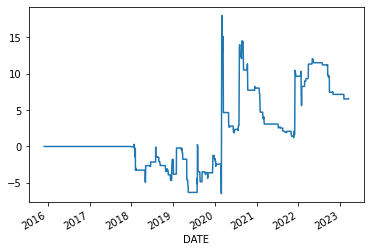

In [376]:
backtest_df.groupby('DATE')['PnL'].sum().cumsum().plot()

In [377]:
backtest_df['hour'] = backtest_df['time'].apply(lambda x: x[0:2])
backtest_df.groupby('hour')['PnL'].sum()

hour
09    -6.562975
10    -1.217758
11     9.400565
12    -2.154951
13    -2.763176
14    -2.528104
15    12.404051
Name: PnL, dtype: float64

In [350]:
backtest_df.groupby(['DATE', 'hour'])['PnL'].sum().sort_values()

DATE        hour
2020-03-16  09     -15.810928
2020-02-28  13     -13.963323
2020-08-24  10      -9.902932
2020-02-28  10      -9.000241
2020-08-03  10      -8.305298
                      ...    
2020-02-28  12      11.864939
            09      13.490723
2020-03-02  09      13.611007
            11      13.947641
2020-08-03  09      36.352780
Name: PnL, Length: 12838, dtype: float64

In [353]:
backtest_df.loc[backtest_df['DATE'] == '2020-07-31'].tail(30)

,TICKER,DATETIME,DATE,time,CLOSE,OPEN,estDayVolume,histDayVolume,todayVsHistVolume,day_upper_20,day_lower_20,current_price_percentile,finish_upper_pred_prod,finish_lower_pred_prod,goal_position,prev_day_midpoint,open_goal_position,exit,prev_exit,prev_close,interval_return,PnL,hour
457138,AAPL,2020-07-31 15:30:00-04:00,2020-07-31,15:30:00,103.56,103.53,3.350024e+10,1.042306e+10,3.214052,101.866,100.49,98.614958,0.740383,0.000050,443.556439,93.91,0.0,NaN,NaN,103.53,0.000290,0.128530,15
457139,AAPL,2020-07-31 15:31:00-04:00,2020-07-31,15:31:00,103.72,103.55,3.354965e+10,1.042306e+10,3.218792,101.866,100.49,99.723757,0.902041,0.000016,338.803108,93.91,0.0,NaN,NaN,103.56,0.001545,0.523450,15
457140,AAPL,2020-07-31 15:32:00-04:00,2020-07-31,15:32:00,103.95,103.72,3.368814e+10,1.042306e+10,3.232079,101.866,100.49,100.000000,0.930176,0.000017,122.095742,93.91,0.0,NaN,NaN,103.72,0.002218,0.270748,15
457141,AAPL,2020-07-31 15:33:00-04:00,2020-07-31,15:33:00,104.07,103.95,3.380616e+10,1.042306e+10,3.243402,101.866,100.49,100.000000,0.929735,0.000016,612.452323,93.91,0.0,NaN,NaN,103.95,0.001154,0.707016,15
457142,AAPL,2020-07-31 15:34:00-04:00,2020-07-31,15:34:00,103.98,104.07,3.390608e+10,1.042306e+10,3.252988,101.866,100.49,99.726027,0.869448,0.000019,702.834203,93.91,0.0,NaN,NaN,104.07,-0.000865,-0.607813,15
457143,AAPL,2020-07-31 15:35:00-04:00,2020-07-31,15:35:00,104.19,103.98,3.399652e+10,1.042306e+10,3.261665,101.866,100.49,100.000000,0.876474,0.000017,705.823900,93.91,0.0,NaN,NaN,103.98,0.002020,1.425495,15
457144,AAPL,2020-07-31 15:36:00-04:00,2020-07-31,15:36:00,104.29,104.19,3.411054e+10,1.042306e+10,3.272604,101.866,100.49,100.000000,0.876474,0.000017,523.307685,93.91,0.0,NaN,NaN,104.19,0.000960,0.502263,15
457145,AAPL,2020-07-31 15:37:00-04:00,2020-07-31,15:37:00,104.18,104.29,3.430622e+10,1.042306e+10,3.291378,101.866,100.49,99.456522,0.825881,0.000017,547.558962,93.91,0.0,NaN,NaN,104.29,-0.001055,-0.577538,15
457146,AAPL,2020-07-31 15:38:00-04:00,2020-07-31,15:38:00,104.25,104.18,3.441455e+10,1.042306e+10,3.301772,101.866,100.49,99.728997,0.871374,0.000016,550.776504,93.91,0.0,NaN,NaN,104.18,0.000672,0.370074,15
457147,AAPL,2020-07-31 15:39:00-04:00,2020-07-31,15:39:00,104.28,104.24,3.454493e+10,1.042306e+10,3.314281,101.866,100.49,99.729730,0.880336,0.000014,396.814415,93.91,0.0,NaN,NaN,104.25,0.000288,0.114191,15


In [354]:
backtest_df.loc[backtest_df['DATE'] == '2020-08-03'].head(20)

,TICKER,DATETIME,DATE,time,CLOSE,OPEN,estDayVolume,histDayVolume,todayVsHistVolume,day_upper_20,day_lower_20,current_price_percentile,finish_upper_pred_prod,finish_lower_pred_prod,goal_position,prev_day_midpoint,open_goal_position,exit,prev_exit,prev_close,interval_return,PnL,hour
457168,AAPL,2020-08-03 09:30:00-04:00,2020-08-03,09:30:00,106.23,106.48,2.616174e+10,1.154627e+10,2.265818,107.97,107.28,100.000000,NaN,NaN,923.653345,100.97,923.653345,False,NaN,104.51,0.016458,15.201261,09
457169,AAPL,2020-08-03 09:31:00-04:00,2020-08-03,09:31:00,106.97,106.25,3.074425e+10,1.154627e+10,2.662700,107.97,107.28,100.000000,NaN,NaN,923.653345,100.97,923.653345,False,NaN,106.23,0.006966,6.434185,09
457170,AAPL,2020-08-03 09:32:00-04:00,2020-08-03,09:32:00,107.32,106.95,3.198933e+10,1.154627e+10,2.770534,107.97,107.28,100.000000,NaN,NaN,923.653345,100.97,923.653345,False,False,106.97,0.003272,3.022143,09
457171,AAPL,2020-08-03 09:33:00-04:00,2020-08-03,09:33:00,107.24,107.31,3.329376e+10,1.154627e+10,2.883509,107.97,107.28,75.000000,NaN,NaN,923.653345,100.97,923.653345,False,False,107.32,-0.000745,-0.688523,09
457172,AAPL,2020-08-03 09:34:00-04:00,2020-08-03,09:34:00,107.59,107.24,3.447377e+10,1.154627e+10,2.985707,107.97,107.28,100.000000,NaN,NaN,923.653345,100.97,923.653345,False,False,107.24,0.003264,3.014534,09
457173,AAPL,2020-08-03 09:35:00-04:00,2020-08-03,09:35:00,107.83,107.57,3.671009e+10,1.154627e+10,3.179391,107.97,107.28,100.000000,NaN,NaN,923.653345,100.97,923.653345,False,False,107.59,0.002231,2.060385,09
457174,AAPL,2020-08-03 09:36:00-04:00,2020-08-03,09:36:00,107.83,107.83,3.653634e+10,1.154627e+10,3.164342,107.97,107.28,92.857143,NaN,NaN,923.653345,100.97,923.653345,False,False,107.83,0.000000,0.000000,09
457175,AAPL,2020-08-03 09:37:00-04:00,2020-08-03,09:37:00,107.53,107.82,3.697291e+10,1.154627e+10,3.202153,107.97,107.28,62.500000,NaN,NaN,923.653345,100.97,923.653345,False,False,107.83,-0.002782,-2.569749,09
457176,AAPL,2020-08-03 09:38:00-04:00,2020-08-03,09:38:00,107.82,107.51,3.644999e+10,1.154627e+10,3.156863,107.97,107.28,77.777778,NaN,NaN,923.653345,100.97,923.653345,False,False,107.53,0.002697,2.491021,09
457177,AAPL,2020-08-03 09:39:00-04:00,2020-08-03,09:39:00,107.92,107.80,3.750425e+10,1.154627e+10,3.248171,107.97,107.28,100.000000,NaN,NaN,923.653345,100.97,923.653345,False,False,107.82,0.000927,0.856662,09


In [340]:
pd.set_option('display.max_columns', None)
backtest_df.loc[backtest_df['DATE'] == '2020-03-13'].tail(10)

,TICKER,DATETIME,DATE,time,CLOSE,OPEN,estDayVolume,histDayVolume,todayVsHistVolume,day_upper_20,day_lower_20,current_price_percentile,finish_upper_pred_prod,finish_lower_pred_prod,goal_position,prev_day_midpoint,open_goal_position,exit,prev_exit,interval_return,PnL,hour,prev_close
419356,AAPL,2020-03-13 15:50:00-04:00,2020-03-13,15:50:00,65.74,65.37,2.035681e+10,1.380828e+10,1.474247,64.22,63.194,100.000000,0.990675,2.639112e-05,0.000000,62.55,-13.524191,NaN,NaN,0.005660,0.000000,15,65.37
419357,AAPL,2020-03-13 15:51:00-04:00,2020-03-13,15:51:00,66.15,65.76,2.042626e+10,1.380828e+10,1.479276,64.22,63.194,100.000000,0.991726,3.849055e-06,0.000000,62.55,-13.524191,NaN,NaN,0.006237,0.000000,15,65.74
419358,AAPL,2020-03-13 15:52:00-04:00,2020-03-13,15:52:00,65.92,66.15,2.052846e+10,1.380828e+10,1.486677,64.22,63.194,99.738903,0.992818,4.085938e-05,0.000000,62.55,-13.524191,NaN,NaN,-0.003477,-0.000000,15,66.15
419359,AAPL,2020-03-13 15:53:00-04:00,2020-03-13,15:53:00,66.18,65.92,2.057754e+10,1.380828e+10,1.490232,64.22,63.194,100.000000,0.992652,3.779428e-06,0.000000,62.55,-13.524191,NaN,NaN,0.003944,0.000000,15,65.92
419360,AAPL,2020-03-13 15:54:00-04:00,2020-03-13,15:54:00,66.65,66.17,2.066826e+10,1.380828e+10,1.496802,64.22,63.194,100.000000,0.997588,4.621950e-08,0.000000,62.55,-13.524191,NaN,NaN,0.007102,0.000000,15,66.18
419361,AAPL,2020-03-13 15:55:00-04:00,2020-03-13,15:55:00,66.48,66.64,2.073945e+10,1.380828e+10,1.501958,64.22,63.194,99.740933,0.998544,4.217904e-08,0.000000,62.55,-13.524191,NaN,NaN,-0.002551,-0.000000,15,66.65
419362,AAPL,2020-03-13 15:56:00-04:00,2020-03-13,15:56:00,66.66,66.47,2.079514e+10,1.380828e+10,1.505991,64.22,63.194,100.000000,0.998732,2.828420e-08,0.000000,62.55,-13.524191,NaN,NaN,0.002708,0.000000,15,66.48
419363,AAPL,2020-03-13 15:57:00-04:00,2020-03-13,15:57:00,67.41,66.67,2.090121e+10,1.380828e+10,1.513672,64.22,63.194,100.000000,0.999300,2.354263e-08,99.514580,62.55,-13.524191,NaN,NaN,0.011251,1.119651,15,66.66
419364,AAPL,2020-03-13 15:58:00-04:00,2020-03-13,15:58:00,67.27,67.41,2.106634e+10,1.380828e+10,1.525631,64.22,63.194,99.742931,0.999302,2.662427e-08,99.577463,62.55,-13.524191,NaN,NaN,-0.002077,-0.206807,15,67.41
419365,AAPL,2020-03-13 15:59:00-04:00,2020-03-13,15:59:00,68.16,67.27,2.115267e+10,1.380828e+10,1.531883,64.22,63.194,100.000000,0.999422,2.348867e-08,99.766628,62.55,-13.524191,NaN,NaN,0.013230,1.319939,15,67.27


<AxesSubplot:>

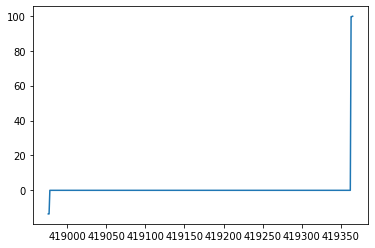

In [334]:
backtest_df.loc[backtest_df['DATE'] == '2020-03-13']['goal_position'].plot()

<AxesSubplot:>

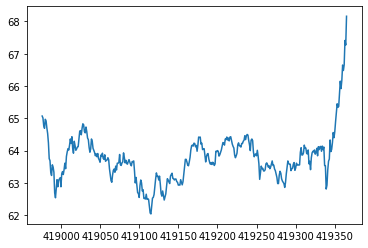

In [335]:
backtest_df.loc[backtest_df['DATE'] == '2020-03-13']['CLOSE'].plot()

<AxesSubplot:>

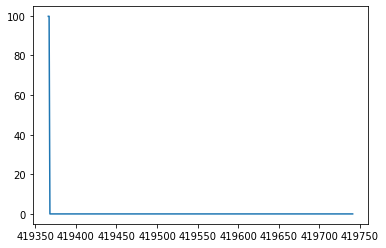

In [336]:
backtest_df.loc[backtest_df['DATE'] == '2020-03-16']['goal_position'].plot()

<AxesSubplot:>

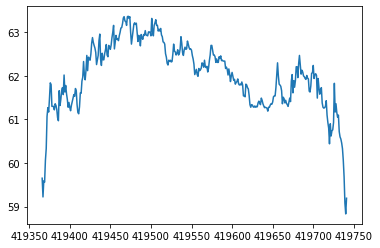

In [337]:
backtest_df.loc[backtest_df['DATE'] == '2020-03-16']['CLOSE'].plot()

<AxesSubplot:>

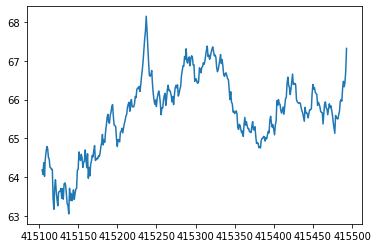

In [325]:
backtest_df.loc[backtest_df['DATE'] == '2020-02-28']['CLOSE'].plot()

<AxesSubplot:>

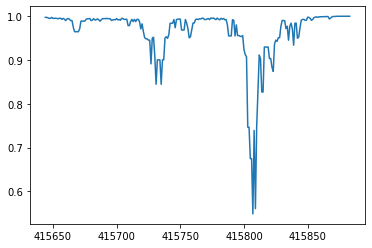

In [307]:
backtest_df.loc[backtest_df['DATE'] == '2020-03-02']['finish_upper_pred_prod'].plot()

In [355]:
temp = backtest_df.copy()
temp['1'] = temp['goal_position'].shift(-1)
temp['2'] = temp['goal_position']
temp['3'] = temp['goal_position'].shift(1)
temp.loc[
    (temp['1'] == 0) & 
    (temp['2'] != 0) &
    (temp['3'] == 0)
]

,TICKER,DATETIME,DATE,time,CLOSE,OPEN,estDayVolume,histDayVolume,todayVsHistVolume,day_upper_20,day_lower_20,current_price_percentile,finish_upper_pred_prod,finish_lower_pred_prod,goal_position,prev_day_midpoint,open_goal_position,exit,prev_exit,prev_close,interval_return,PnL,hour,1,2,3
202852,AAPL,2017-12-26 12:06:00-05:00,2017-12-26,12:06:00,40.4300,40.44,5.887281e+09,3.837271e+09,1.534236,40.490,40.430,28.025478,0.469733,0.285095,49.407406,41.550,0.000000,NaN,NaN,40.4400,-0.000247,-0.012217,12,0.0,49.407406,0.0
202917,AAPL,2017-12-26 13:11:00-05:00,2017-12-26,13:11:00,40.4300,40.42,5.547821e+09,3.837271e+09,1.445772,40.490,40.430,25.225225,0.486474,0.149088,49.407406,41.550,0.000000,NaN,NaN,40.4200,0.000247,0.012224,13,0.0,49.407406,0.0
202948,AAPL,2017-12-26 13:42:00-05:00,2017-12-26,13:42:00,40.4300,40.44,5.511811e+09,3.837271e+09,1.436388,40.490,40.430,23.122530,0.474467,0.214036,46.567173,41.550,0.000000,NaN,NaN,40.4400,-0.000247,-0.011515,13,0.0,46.567173,0.0
210884,AAPL,2018-01-25 15:58:00-05:00,2018-01-25,15:58:00,40.6400,40.64,6.178327e+09,3.793350e+09,1.628726,41.150,40.640,19.794344,0.000084,0.299402,-2.030559,41.450,-269.456517,NaN,NaN,40.6400,0.000000,-0.000000,15,0.0,-2.030559,0.0
211542,AAPL,2018-01-29 13:56:00-05:00,2018-01-29,13:56:00,40.0000,40.00,7.344188e+09,4.092672e+09,1.794473,40.070,39.890,36.142322,0.000075,0.685113,-10.845460,40.590,0.000000,NaN,NaN,40.0000,0.000000,-0.000000,13,0.0,-10.845460,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703069,AAPL,2023-02-02 14:57:00-05:00,2023-02-02,14:57:00,148.9700,149.10,1.278869e+10,8.288003e+09,1.543036,149.972,149.068,16.463415,0.072539,0.701086,-9.391565,142.570,0.000000,NaN,NaN,149.1000,-0.000872,0.008188,14,0.0,-9.391565,0.0
703091,AAPL,2023-02-02 15:19:00-05:00,2023-02-02,15:19:00,149.2800,149.20,1.298822e+10,8.288003e+09,1.567111,149.972,149.068,31.142857,0.120282,0.575675,-3.764195,142.570,0.000000,NaN,NaN,149.1900,0.000603,-0.002271,15,0.0,-3.764195,0.0
703303,AAPL,2023-02-03 12:21:00-05:00,2023-02-03,12:21:00,156.3900,156.51,2.439850e+10,8.494879e+09,2.872142,155.980,154.460,77.616279,0.618063,0.000016,414.821803,149.690,65.814252,NaN,NaN,156.5200,-0.000831,-0.344536,12,0.0,414.821803,0.0
713132,AAPL,2023-03-13 13:40:00-04:00,2023-03-13,13:40:00,151.7699,151.70,1.166808e+10,7.358459e+09,1.585669,152.286,151.008,56.573705,0.694675,0.000261,0.975270,149.202,0.000000,NaN,NaN,151.6912,0.000519,0.000506,13,0.0,0.975270,0.0


In [357]:
temp.loc[temp['DATETIME'] >= pd.to_datetime('2017-12-26 12:00:00-05:00')].head(12)

,TICKER,DATETIME,DATE,time,CLOSE,OPEN,estDayVolume,histDayVolume,todayVsHistVolume,day_upper_20,day_lower_20,current_price_percentile,finish_upper_pred_prod,finish_lower_pred_prod,goal_position,prev_day_midpoint,open_goal_position,exit,prev_exit,prev_close,interval_return,PnL,hour,1,2,3
202846,AAPL,2017-12-26 12:00:00-05:00,2017-12-26,12:00:00,40.42,40.43,5.915916e+09,3.837271e+09,1.541699,40.49,40.43,23.841060,0.468420,0.382770,0.000000,41.55,0.0,NaN,True,40.43,-0.000247,-0.000000,12,0.000000,0.000000,0.000000
202847,AAPL,2017-12-26 12:01:00-05:00,2017-12-26,12:01:00,40.42,40.42,5.912463e+09,3.837271e+09,1.540799,40.49,40.43,24.013158,0.468420,0.382770,0.000000,41.55,0.0,NaN,True,40.42,0.000000,0.000000,12,0.000000,0.000000,0.000000
202848,AAPL,2017-12-26 12:02:00-05:00,2017-12-26,12:02:00,40.41,40.42,5.914230e+09,3.837271e+09,1.541259,40.49,40.43,21.241830,0.428789,0.418662,0.000000,41.55,0.0,NaN,NaN,40.42,-0.000247,-0.000000,12,0.000000,0.000000,0.000000
202849,AAPL,2017-12-26 12:03:00-05:00,2017-12-26,12:03:00,40.43,40.41,5.907709e+09,3.837271e+09,1.539560,40.49,40.43,28.246753,0.469733,0.285095,0.000000,41.55,0.0,NaN,NaN,40.41,0.000495,0.000000,12,0.000000,0.000000,0.000000
202850,AAPL,2017-12-26 12:04:00-05:00,2017-12-26,12:04:00,40.45,40.43,5.911537e+09,3.837271e+09,1.540557,40.49,40.43,37.096774,0.823519,0.146919,0.000000,41.55,0.0,NaN,NaN,40.43,0.000495,0.000000,12,0.000000,0.000000,0.000000
202851,AAPL,2017-12-26 12:05:00-05:00,2017-12-26,12:05:00,40.44,40.45,5.901523e+09,3.837271e+09,1.537948,40.49,40.43,32.371795,0.581204,0.270294,0.000000,41.55,0.0,NaN,NaN,40.45,-0.000247,-0.000000,12,49.407406,0.000000,0.000000
202852,AAPL,2017-12-26 12:06:00-05:00,2017-12-26,12:06:00,40.43,40.44,5.887281e+09,3.837271e+09,1.534236,40.49,40.43,28.025478,0.469733,0.285095,49.407406,41.55,0.0,NaN,NaN,40.44,-0.000247,-0.012217,12,0.000000,49.407406,0.000000
202853,AAPL,2017-12-26 12:07:00-05:00,2017-12-26,12:07:00,40.43,40.44,5.875172e+09,3.837271e+09,1.531081,40.49,40.43,28.164557,0.469733,0.285095,0.000000,41.55,0.0,NaN,NaN,40.43,0.000000,0.000000,12,0.000000,0.000000,49.407406
202854,AAPL,2017-12-26 12:08:00-05:00,2017-12-26,12:08:00,40.45,40.43,5.864660e+09,3.837271e+09,1.528341,40.49,40.43,38.364780,0.823519,0.146919,0.000000,41.55,0.0,NaN,NaN,40.43,0.000495,0.000000,12,0.000000,0.000000,0.000000
202855,AAPL,2017-12-26 12:09:00-05:00,2017-12-26,12:09:00,40.46,40.45,5.862949e+09,3.837271e+09,1.527895,40.49,40.43,43.437500,0.848116,0.155430,0.000000,41.55,0.0,NaN,NaN,40.45,0.000247,0.000000,12,49.407406,0.000000,0.000000
